# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
from pathlib import Path
import project_tests as t
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

DATA_DIR = Path("data")
INTERACTIONS_FILE = DATA_DIR / "user-item-interactions.csv"
ARTICLES_FILE = DATA_DIR / "articles_community.csv"

In [2]:
def load_data():
    """Load CSVs, dropping unnamed index columns on the fly."""
    df = pd.read_csv(INTERACTIONS_FILE, usecols=lambda c: c != "Unnamed: 0")
    df_content = pd.read_csv(ARTICLES_FILE, usecols=lambda c: c != "Unnamed: 0")
    return df, df_content

df, df_content = load_data()

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
def user_interaction_distribution(df: pd.DataFrame) -> tuple[int, int]:
    """Plot and print summary stats for user–article interactions.
    
    Returns:
      median_val: 50% threshold of per-user interactions
      max_views:  maximum interactions by any single user
    """
    interactions_per_user = df.groupby("email")["article_id"].size()

    # Histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    interactions_per_user.hist(bins=50, ax=ax)
    ax.set_title("Distribution of Article Interactions per User")
    ax.set_xlabel("Number of Articles Interacted")
    ax.set_ylabel("Number of Users")
    plt.tight_layout()
    plt.show()

    # Summary stats
    median_val = int(interactions_per_user.median())
    max_views  = int(interactions_per_user.max())
    print(f"50% of individuals interact with {median_val} articles or fewer.")
    print(f"The maximum number of user-article interactions by any 1 user is {max_views}.")

    return median_val, max_views


def basic_stats(df: pd.DataFrame, df_content: pd.DataFrame) -> dict:
    """Return key dataset metrics as a dict."""
    return {
        "unique_articles_interacted": df["article_id"].nunique(),
        "unique_articles_total": df_content["article_id"].nunique(),
        "unique_users": df["email"].nunique(),
        "num_interactions": len(df),
    }


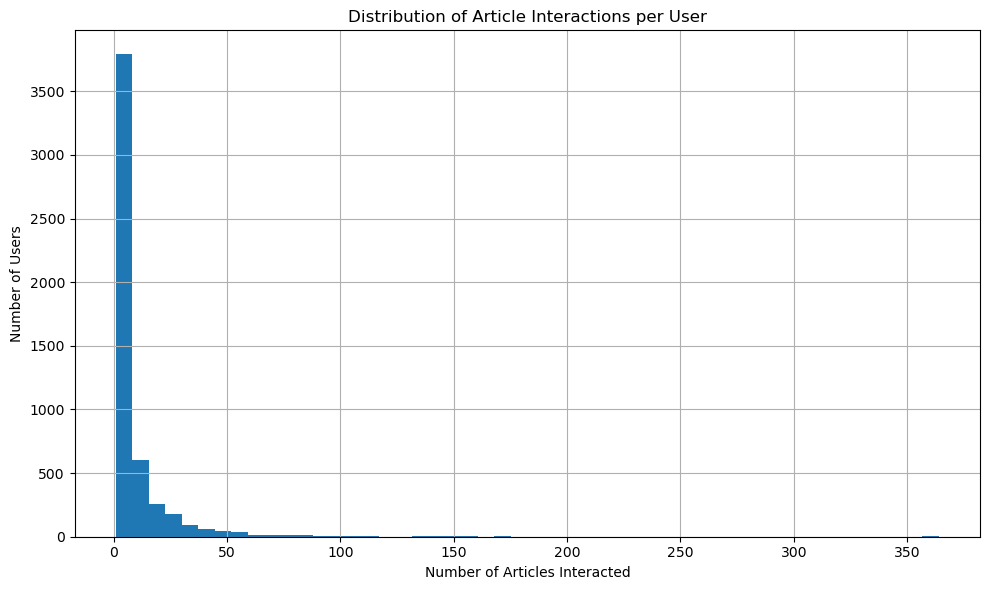

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.

--- Dataset Overview ---
Unique Articles Interacted: 714
Unique Articles Total: 1051
Unique Users: 5148
Num Interactions: 45993


In [4]:
# Visualization + stats
median_val, max_views_by_user = user_interaction_distribution(df)    

# Summary statistics
stats = basic_stats(df, df_content)   
print("\n--- Dataset Overview ---")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Identify duplicate article_id rows and report the exact count.
duplicate_count = df_content["article_id"].duplicated(keep=False).sum()
print(f"Duplicate article_id rows: {duplicate_count}")

Duplicate article_id rows: 10


In [6]:
# Remove duplicate articles, keeping the first occurrence
def remove_duplicate_articles(df_content: pd.DataFrame) -> pd.DataFrame:
    """Return DataFrame with duplicate *article_id* rows removed (preserving the first occurrence)."""
    mask_first = ~df_content["article_id"].duplicated(keep="first")
    return df_content.loc[mask_first].reset_index(drop=True)

print(f"Article rows before dedupe: {len(df_content)}")
#remove duplicate
df_content = remove_duplicate_articles(df_content)

# Normalize article_id in df_content and build a lookup dict
df_content["article_id_str"] = df_content["article_id"].astype(str)
title_lookup = (
    df_content
    .assign(article_id_str=df_content["article_id"].astype(str))
    .set_index("article_id_str")["doc_full_name"]
)

#verify
print(f"Article rows after dedupe: {len(df_content)}")

Article rows before dedupe: 1056
Article rows after dedupe: 1051


In [7]:
# Check if there are still duplicates
duplicate_count = df_content["article_id"].duplicated(keep=False).sum()
print(f"Duplicate article_id rows: {duplicate_count}")

Duplicate article_id rows: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
# a) Number of unique articles that have at least one interaction
unique_articles = int(df["article_id"].nunique())

# b) Number of unique articles in the full dataset
total_articles = int(df_content["article_id"].nunique())

# c) Number of unique users (excluding null emails)
unique_users = int(df["email"].nunique())

# d) Total number of user–article interactions
user_article_interactions = len(df)

# Print them out
print(f"a) Unique articles with interactions:       {unique_articles}")
print(f"b) Total unique articles in dataset:        {total_articles}")
print(f"c) Unique users (excluding null values):    {unique_users}")
print(f"d) Total user–article interactions:        {user_article_interactions}")

a) Unique articles with interactions:       714
b) Total unique articles in dataset:        1051
c) Unique users (excluding null values):    5148
d) Total user–article interactions:        45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
# most viewed article_id
article_counts = df["article_id"].value_counts()
most_viewed_article_id = str(article_counts.idxmax())
max_views = int(article_counts.max())

print(f"Most-viewed article_id: {most_viewed_article_id} ({max_views} views)")

Most-viewed article_id: 1429.0 (937 views)


In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
title_lookup = df_content.set_index("article_id")["doc_full_name"]
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = (
        df['title']
          .dropna()           # ignore missing titles
          .value_counts()     # count views per title
          .nlargest(n)        # pick top n counts
          .index
          .tolist()
    )
    return top_articles  # Return the top article titles

    

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # directly grab the top-n IDs as ints

    top_article_ids = df['article_id'].astype(int).value_counts().head(n).index.tolist()
    return top_article_ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df2 = df.copy()
    
    # 1) Ensure article_id is string (so column labels stay consistent)
    df2['article_id'] = df2['article_id'].astype(str)
    
    # 2) Count interactions per (user, article)
    counts = df2.groupby(['user_id', 'article_id']).size()
    
    # 3) Pivot into a user–item matrix, filling missing with 0
    user_item = counts.unstack(fill_value=0)
    
    # 4) Convert any positive counts to 1’s
    user_item = (user_item > 0).astype(int)
    
    return user_item

user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    
    # create list of just the ids
    most_similar_users = list(similarity.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    lookup = dict(zip(
        df['article_id'].astype(str),
        df['title']
    ))
    # Preserve order and fall back to '' if missing
    article_names = [ lookup.get(str(aid), '') for aid in article_ids ]
    
    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Grab the string‐IDs of the columns where the value is 1
    seen_mask  = user_item.loc[user_id] == 1
    article_ids = user_item.columns[seen_mask].tolist()
    
    # Map to names
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = []
    # set of string‐IDs the target user has already seen
    seen = set(user_item.columns[user_item.loc[user_id] == 1])
    
    for other in find_similar_users(user_id):
        seen_by_other = user_item.columns[user_item.loc[other] == 1]
        for aid in seen_by_other:
            if aid not in seen and aid not in recs:
                recs.append(aid)
                if len(recs) >= m:
                    return recs
    
    return recs  # return your recommendations for this user_id

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [67]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here    
    # vectorized similarity
    sim = user_item.dot(user_item.loc[user_id])
    # total interactions count per user (including repeat views)
    counts_total = df.groupby('user_id')['title'].count()
    # align with sim index
    counts = counts_total.reindex(sim.index).fillna(0).astype(int)

    # assemble DataFrame
    neighbors_df = pd.DataFrame({
        'neighbor_id': sim.index.astype(int),
        'similarity': sim.values,
        'num_interactions': counts.values
    })
    # remove self and sort
    neighbors_df = (
        neighbors_df[neighbors_df['neighbor_id'] != user_id]
        .sort_values(['similarity', 'num_interactions'], ascending=False)
        .reset_index(drop=True)
    )
    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here 
    # articles already seen
    seen_ids, _ = get_user_articles(user_id)
    # top neighbors
    neighbors = get_top_sorted_users(user_id)['neighbor_id'].tolist()
    # count neighbor interactions by article
    candidate_counts = (
        df[df['user_id'].isin(neighbors)]['article_id']
        .value_counts()
    )
    # select top m unseen articles
    recs = [aid for aid in candidate_counts.index if aid not in seen_ids][:m]
    # fetch their names
    rec_names = get_article_names(recs)
    return recs, rec_names


In [68]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [69]:
	
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].head(10).values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].head(10).values[-1] # Find the 10th most similar user to user 13

In [70]:
## Dictionary Test Here

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**For a brand‐new user with no history, the safest approach is to start by recommending the site’s most popular articles. That lets you quickly gather data on their tastes. Once they’ve interacted with a few pieces, you can switch to collaborative filtering—matching them to users with similar reading patterns to deliver more personalized suggestions.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [73]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = new_user_recs = (
    df['article_id']
      .astype(str)              
      .value_counts()            
      .head(10)                
      .index
      .tolist()                  
)# Your recommendations here

In [74]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [75]:
# Load the matrix here
user_item_matrix = create_user_item_matrix(df)

In [76]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [83]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
# 1) grab the raw array (floats)
X = user_item_matrix.values.astype(float)

# 2) economy SVD
u, s, vt = np.linalg.svd(X, full_matrices=False)

In [78]:
# explained variance
import numpy as np

n_components = 500

# squared singular values
sing_vals_sq = s**2

# total variance
total_var = sing_vals_sq.sum()

# variance explained by the top n_components
var_exp = sing_vals_sq[:n_components].sum()

# percentage explained
perc_exp = np.round(var_exp / total_var * 100, 4)

print(f"Top {n_components} components explain {perc_exp}% of the variance.")

Top 500 components explain 98.8465% of the variance.


**user_item_matrix only contains 0 and 1 without any missing values, therefore SVD can be used.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [79]:
import matplotlib.pyplot as plt

# 1) Economy SVD
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)
# Pre-scale U by the singular values
u_s = u * s  # shape = (n_users, n_components)

# 2) Choose the k’s you want to test
num_latent_feats = np.arange(10, min(u_s.shape[1], vt.shape[0]) + 1, 20)

# 3) Total entries for normalization
total_cells = user_item_matrix.size  # same as n_users * n_items

# 4) Compute reconstruction error for each k
errors = []
for k in num_latent_feats:
    # Reconstruct with top-k
    est = np.around(u_s[:, :k] @ vt[:k, :])
    # Sum absolute deviations
    errors.append(np.abs(user_item_matrix - est).sum())

# 5) Convert to accuracy
accuracy = 1 - (np.array(errors) / total_cells)

# 6) Plot
plt.figure(figsize=(8, 5))
plt.plot(num_latent_feats, accuracy, marker='o')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.grid(True)

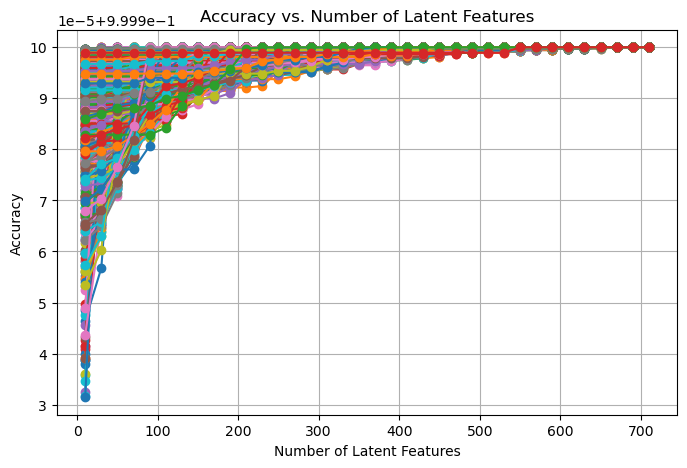

In [80]:
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [81]:
def make_user_item_df(df):
    
    # build user-item DataFrame
    user_item_df = df.groupby(['user_id','article_id'])['title'].count().unstack()
    
    # where notnull, place a 1, else 0
    user_item_matrix = np.where(user_item_df.isnull(), 0, 1)
    
    # create user_item_matrix_df
    user_item_matrix_df = pd.DataFrame(
        user_item_matrix,
        index=user_item_df.index,
        columns=user_item_df.columns
    )
    
    return user_item_matrix_df


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # train and test user-item matrices
    user_item_train = make_user_item_df(df_train)
    user_item_test  = make_user_item_df(df_test)

    # extract test indices
    test_idx  = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    # sets for membership checks
    train_users    = set(user_item_train.index)
    train_articles = set(user_item_train.columns)
    test_users     = set(test_idx)
    test_articles  = set(test_arts)

    # compute prediction vs cold-start counts
    n_pred_users          = len(test_users & train_users)
    n_cold_start_users    = len(test_users - train_users)
    n_pred_articles       = len(test_articles & train_articles)
    n_cold_start_articles = len(test_articles - train_articles)

    return (
        user_item_train,
        user_item_test,
        test_idx,
        test_arts,
        n_pred_users,
        n_cold_start_users,
        n_pred_articles,
        n_cold_start_articles
    )

In [84]:
(
    user_item_train,
    user_item_test,
    test_idx,
    test_arts,
    n_pred_users,
    n_cold_start_users,
    n_pred_articles,
    n_cold_start_articles
) = create_test_and_train_user_item(df_train, df_test)

print(f"Can predict for {n_pred_users} users; cold‐start for {n_cold_start_users}.")
print(f"Can predict for {n_pred_articles} articles; cold‐start for {n_cold_start_articles}.")

Can predict for 20 users; cold‐start for 662.
Can predict for 574 articles; cold‐start for 0.


In [86]:
#How many users can we make predictions for in the test set?
n_pred_users = user_item_test.index.intersection(user_item_train.index).size
n_pred_users

20

In [87]:
#How many users in the test set are we not able to make predictions for because of the cold start problem?
n_cold_users = user_item_test.index.difference(user_item_train.index).size
n_cold_users

662

In [88]:
#How many articles can we make predictions for in the test set?
n_pred_articles = user_item_test.columns.intersection(user_item_train.columns).size
n_pred_articles

574

In [89]:
#How many articles in the test set are we not able to make predictions for because of the cold start problem?
n_cold_articles = user_item_test.columns.difference(user_item_train.columns).size
n_cold_articles

0

In [90]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,  
    'How many articles can we make predictions for in the test set?': b, 
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d 
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [91]:
# fit SVD on the user_item_train matrix
# 1) Get the raw array and ensure it’s floats
X_train = user_item_train.values.astype(float)

# 2) Compute the economy‐size SVD
u_train, s_train, vt_train = np.linalg.svd(X_train, full_matrices=False)

In [92]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
# 1) Economy SVD on the training matrix
X_train = user_item_train.values.astype(float)
u_train, s_train, vt_train = np.linalg.svd(X_train, full_matrices=False)

# Pre-scale U by singular values for faster reconstruction
u_s_train = u_train * s_train

# 2) Prepare the test‐subset slices
user_mask = user_item_train.index.isin(test_idx)
item_mask = user_item_train.columns.isin(test_arts)

u_test_s = u_s_train[user_mask, :]               # test users’ rows
vt_test  = vt_train[:, item_mask]                # test items’ columns
X_test   = user_item_test.loc[
               user_item_train.index[user_mask],
               user_item_train.columns[item_mask]
           ].values.astype(float)

# 3) Define range of latent features and total counts
max_k = min(u_s_train.shape[1], vt_train.shape[0])
num_latent_feats = np.arange(10, max_k + 1, 20)
total_train = X_train.size
total_test  = X_test.size

# 4) Compute train/test accuracy for each k
acc_train = []
acc_test  = []
for k in num_latent_feats:
    # Reconstruct with top-k components
    X_train_est = np.around(u_s_train[:, :k] @ vt_train[:k, :])
    X_test_est  = np.around(u_test_s[:, :k]    @ vt_test[:k, :])
    
    # Sum absolute errors
    err_train = np.abs(X_train - X_train_est).sum()
    err_test  = np.abs(X_test  - X_test_est ).sum()
    
    # Convert to accuracy
    acc_train.append(1 - err_train / total_train)
    acc_test.append(1 - err_test  / total_test)

# 5) Plot accuracy vs latent features
plt.figure(figsize=(8, 5))
plt.plot(num_latent_feats, acc_train, marker='o')
plt.plot(num_latent_feats, acc_test,  marker='o')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend(['Train', 'Test'])
plt.grid(True)

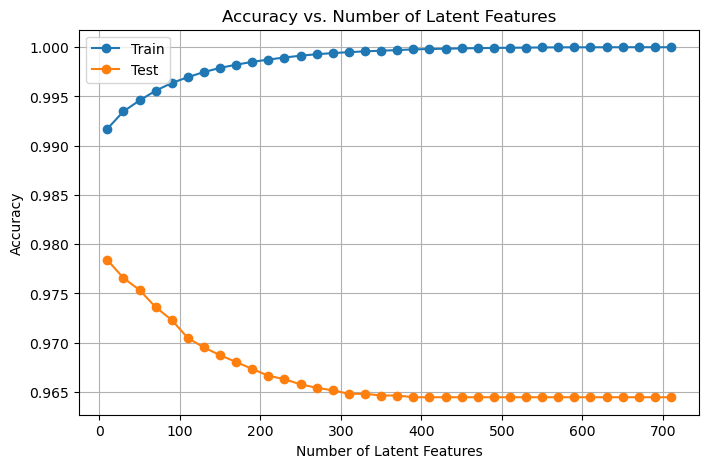

In [93]:
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Although I can perfectly reconstruct my training data by cranking up the number of SVD dimensions, that doesn’t actually improve—and can even hurt—my ability to predict new clicks. To really know whether my recommendations work, I combine simple offline tests (for example, holding out some interactions and measuring precision@K or recall@K) with live experiments. I might A/B-test my new engine against the existing “most popular” baseline to see which drives more clicks or longer sessions. I can also interleave suggestions from both models on the same page to get instant feedback on what people actually click. Finally, I’ll gather direct user feedback (surveys or ratings) and always tie my results back to core business metrics—whether that’s sign-ups, ad revenue, or deeper engagement.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [94]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 612034 bytes to Recommendations_with_IBM.html


0